<a href="https://colab.research.google.com/github/isakhammer/deep_learning_project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np
from copy import deepcopy as copy 
import matplotlib.pyplot as plt


**1. Implement functions for generating synthetic input data**


$$
f_1(p,q) = \frac{1}{2}q^2 + \frac{1}{2}p^2
$$

$$
f_2(p,q) = \frac{1}{2}q^2 
$$

$$
f_4(y) = 1 - cos(y)
$$



In [73]:

def generate_synthetic_batches(I,func = "2sqr"):
    
    batch = {} 
    
    if func == "2sqr":
        
        d_0 = 2
        batch["Y"] = np.random.uniform(high=2, low=-2, size=(d_0,I) )    
        batch["c"] = 0.5*batch["Y"][0,:]**2 + 0.5*batch["Y"][1,:]**2
        batch["c"] = batch["c"][:, np.newaxis]
        
        return batch
    
    elif func == "1sqr":
        d_0 = 1
        
        batch["Y"] = np.random.uniform(high=2, low=-2, size=(d_0,I) )
        batch["c"] = 0.5*(batch["Y"])**2
        batch["c"] = batch["c"].T
        
        return batch
    
    elif func == "1cos":
        d_0 = 1
        
        batch["Y"] = np.random.uniform(high=np.pi/3, low=-np.pi/3, size=(d_0,I) )
        batch["c"] = 1 - np.cos(batch["Y"])
        batch["c"] = batch["c"].T
        
        return batch
    
    else:
        raise Exception("Not axeped func")


**2. Implement the neural network for training approximation of Hamiltonian function**





$$
\tilde{F}(Y; \theta) = \eta((Z^{(K)})^T w + \mu \mathbf{1} ) 
$$
where 
$$
Z^{(k+1)} = Z^{(K)} + h  \sigma(W_k Z^{(k)} + b_1 ) \\
Z^{(0)} = \hat{I} Y.
$$
Here is a

$$
\hat{I} = 
\begin{bmatrix}
I_{d_0 \times d_0} \\
0
\end{bmatrix}
$$

The cost function is on the form 

$$
J(\theta) = \frac{1}{2} \lVert  \tilde{F} (Y; \theta) - c \rVert 
$$

where the gradient is define as 
...





In [74]:


def sigma(x, derivative=False):   
    if (derivative):
        return 1 / np.cosh(x)**2 
    return np.tanh(x)

def eta(x, derivative=False, identity=False):
    if identity==True:
        if (derivative):
            return np.ones(x.shape)
        return x
    else:
        if (derivative):
            return 0.25*(np.cosh(0.5*x) )**(-2)
        return 0.5*np.tanh(0.5*x) + 0.5

def F_tilde(Y, th, d_0, d, K, h):
    
    Z = {}
    I_d = np.identity(d)[:,:d_0]
    Z[0] = I_d@Y

    for k in range(K):
        Z_hat = th["W"][k]@Z[k]+th["b"][k]
        Z[k+1] = Z[k] + h*sigma(Z_hat, False)
    
    Upsilon = eta(Z[K].T@th["w"]+th["mu"])
    
    return Z, Upsilon 


def grad_J(c ,Y, th, d_0, d_k, K, h):
    
    I =  Y.shape[1]
    
    # Equation 5
    Z, Upsilon, dUpsilon, dsigma = F_tilde(Y, th, d_0, d_k, K, h) 
    
    # Equation 6
    J = 0.5*np.linalg.norm(Upsilon - c)**2

    # Initializing gradient
    dJ = {}

    # Equation (8)  
    dJ["mu"]   =  dUpsilon.T@(Upsilon - c)
        
    # Equation (9)
    dJ["w"] = Z[K]@((Upsilon - c)* dUpsilon)
        
    # Equation (10)
    P = np.zeros(( K+1, d_k, I))
    P[-1] = th["w"] @ ((Upsilon - c)* dUpsilon).T
        
    # Equation 11
    for k in range(K-1,-1,-1):
        P[k] = P[k+1] + h*th["W"+str(k)].T @ (dsigma[k] * P[k+1])  
    
    for k in range(0, K):
        # Equation 12
        dJ["W"+str(k)] = h*(P[k+1] * dsigma[k])@(Z[k]).T
        
        # Equation 13
        dJ["b"+str(k)] = h*(P[k+1] * dsigma[k])@np.ones((I,1))
    
    return J, dJ


def J_func(Upsilon, c):
    return 0.5*np.linalg.norm(c - Upsilon)**2


def dJ_func(c, Y, th, d_0, d, K, h):
    Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
    I = Upsilon.shape[0]
        
    etahat = eta(Z[K].T@th["w"] + th["mu"]*np.ones(( I, 1)), derivative=True )
        
    P = np.zeros(( K+1, d, I))
    
    P[K] = np.outer(th["w"], ( (Upsilon - c)* etahat).T)
        
    dJ_mu = etahat.T @(Upsilon - c)
        
    dJ_w = Z[K] @ ((Upsilon - c) * etahat)
        
    for k in range(K, 0, -1):
        P[k-1] = P[k] + h*th["W"][k-1].T @ (sigma(th["W"][k-1]@Z[k-1]+np.outer(th["b"][k-1],np.ones(I)), True) * P[k])
            
    dJ_W = np.zeros((K, d, d))
    dJ_b = np.zeros((K, d, 1))
        
    for k in range(K):
        dsigma = sigma(th["W"][k]@Z[k]+np.outer(th["b"][k],np.ones(I)),True)
            
        dJ_W[k] = h*(P[k+1]*dsigma) @ Z[k].T
        dJ_b[k] = (h*(P[k+1]*dsigma) @ np.ones(I))[:,np.newaxis]
    dJ = {}
    dJ["w"], dJ["mu"], dJ["W"], dJ["b"] = dJ_w, dJ_mu, dJ_W, dJ_b

    return dJ



def initialize_weights(d_0, d, K):
    th = {}
    
    th["W"] = np.zeros((K, d, d))
    th["b"] = np.zeros((K, d, 1))
    
    for i in range(K):
        th["W"][i] = np.identity(d)
        th["b"][i] = np.zeros((d, 1))
            
    th["w"] = np.ones((d, 1 ))
    th["mu"] = np.zeros((1, 1))
    
    return th




def gradientDesent(K, th, dJ, tau):
    
    th["mu"] = th["mu"] - tau*dJ["mu"]
    th["w"] = th["w"] - tau*dJ["w"]
    
    th["W"] = th["W"] -  tau*dJ["W"]
    th["b"] = th["b"] -  tau*dJ["b"]
    
    return th


def adam_algebra(th, dJ, v, m, key, j):
    beta_1, beta_2 =  0.9, 0.999
    alpha, epsilon = 10**(-5), 10**(-8)
    
    
    g = dJ[key] 
    m[key] = beta_1*m[key] + (1- beta_1)*g
    v[key] = beta_2*v[key] + (1 - beta_2)*(g*g)
    mhat = m[key]/(1 - beta_1**(j+1))
    vhat = v[key]/(1 - beta_2**(j+1))
    th[key] -= alpha*mhat/(np.square(vhat) + epsilon)
    #print("hat",  vhat, v[key], mhat, m[key], j+1 )
    return th, v, m

def scale(x, alpha=0, beta=1, returnParameters = False):
    
    a = np.min(x)
    b = np.max(x)
    
    if returnParameters:
        
        return alpha, beta, a, b
        
    else:
        
        def  invscale(x):
            return ((x+alpha)*b - (x-beta)*a) / (beta-alpha)
        
        return ( (b - x)*alpha + (x - a)*beta)/(b - a), invscale
    

def invscaleparameter(x, alpha, beta, a, b):
    return ((x+alpha)*b - (x-beta)*a) / (beta-alpha)    


def train(c, d, d_0, K, h, Y, th, tau=0.0005, max_it=60, print_it=False, method="gd"):
    # compute Zk
    err = np.inf
    tol = 0.01
    
    
    itr = 0
    Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
    JJ = np.zeros(max_it+1)
    err = J_func(Upsilon,c)
    
    JJ[0] = err
    
    # Adam parameters 
    m = {}
    m["mu"] = np.zeros(th["mu"].shape)
    m["w"] = np.zeros(th["w"].shape)
    m["W"] = np.zeros(th["W"].shape)
    m["b"] = np.zeros(th["b"].shape)
    v = copy(m)
    
    while (itr < max_it ):
        
        Z, Upsilon = F_tilde(Y, th, d_0, d, K, h)
        
        
        
        if (method=="gd"):
            dJ = dJ_func(c, Y, th, d_0, d, K, h)
            th = gradientDesent(K, th, dJ, tau)
        
        elif (method=="adam"):
            j = itr
            
            dJ = dJ_func(c, Y, th, d_0, d, K, h)
            
            th, v, m = adam_algebra(th, dJ, v, m, "mu", j)
            th, v, m = adam_algebra(th, dJ, v, m, "w", j)
            th, v, m = adam_algebra(th, dJ, v, m, "W", j)
            th, v, m = adam_algebra(th, dJ, v, m, "b", j)
            
        else:
            print("No optimization method")
        
        err = J_func(Upsilon, c)  
        
        JJ[itr+1] = err
        
        itr += 1
        
        if(itr%50 == 0) and (print_it == True):
            print(itr,err)
        
    return JJ , th



(a) Test the model by using the suggested functions

In [75]:
def generate_synthetic_batches(I,func="2sqr"):
    
    batch = {} 
    
    if func == "2sqr":
        
        d_0 = 2
        
        batch["Y"] = np.random.uniform(high=2, low=-2, size=(d_0,I) )    
    
    
        batch["c"] = 0.5*batch["Y"][0,:]**2 + 0.5*batch["Y"][1,:]**2
        batch["c"] = batch["c"][:, np.newaxis]
        
        return batch
    
    elif func == "1sqr":
        d_0 = 1
        
        batch["Y"] = np.random.uniform(high=2, low=-2, size=(d_0,I) )
        batch["c"] = 0.5*(batch["Y"])**2
        batch["c"] = batch["c"].T
        
        return batch
    
    elif func == "1cos":
        d_0 = 1
        
        batch["Y"] = np.random.uniform(high=np.pi/3, low=-np.pi/3, size=(d_0,I) )
        batch["c"] = 1 - np.cos(batch["Y"])
        batch["c"] = batch["c"].T
        
        return batch
    
    elif func == "2norm-1":
        batch["Y"] = np.random.uniform(high=2, low=-2, size=(d_0,I))
        
        origo = np.zeros((d_0,1))
        
        for y in batch["Y"].T:
            if (y == origo):
                y = np.array([0.1,0.1])
        
        batch["c"] = 1 - np.cos(batch["Y"])
        batch["c"] = batch["c"].T
            
        return batch
        
    
    else:
        raise Exception("Not axeped func")
        

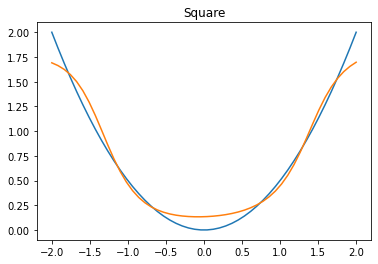

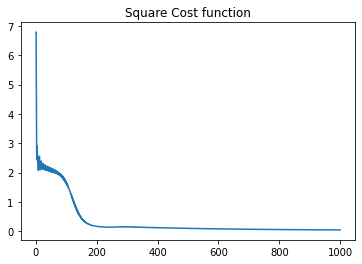

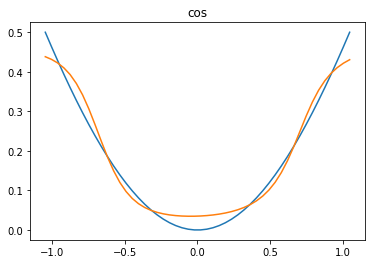

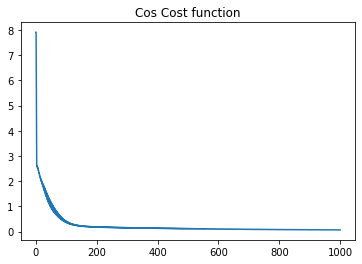

In [76]:

def sqr_test():
    b = generate_synthetic_batches(I,"1sqr")

    Y = b["Y"]
    c, inv = scale(b["c"])

    d_0 = Y.shape[0]
    d = d_0*2

    th = initialize_weights(d_0, d, K)
    JJ, th = train(c, d, d_0, K, h, Y, th, tau, max_it, method="gd")
    
    x = np.linspace(-2, 2, I)
    x = np.reshape(x,(1,len(x)))
    y = 1/2 *x**2
    
    z, yhat = F_tilde(x, th, d_0, d, K, h)
    yhat = inv(yhat)
    yhat = yhat.T

    plt.title("Square")
    plt.plot(x.T,y.T)
    plt.plot(x.T,yhat.T)
    plt.show()
    
    plt.title("Square Cost function")
    plt.plot(JJ)
    plt.show()


def cos_test():
    b = generate_synthetic_batches(I,"1cos")

    Y = b["Y"]
    c, inv = scale(b["c"])

    d_0 = Y.shape[0]
    d = d_0*2

    th = initialize_weights(d_0, d, K)
    JJ, th = train(c, d, d_0, K, h, Y, th, tau, max_it, method="gd")
    
    x = np.linspace(- np.pi/3, np.pi/3, I)
    x = np.reshape(x,(1,len(x)))
    y = 1 - np.cos(x)
    
    z, yhat = F_tilde(x, th, d_0, d, K, h)
    yhat = inv(yhat)
    yhat = yhat.T

    plt.title("cos")
    plt.plot(x.T,y.T)
    plt.plot(x.T,yhat.T)
    plt.show()
    
    plt.title("Cos Cost function")

    plt.plot(JJ)
    plt.show()

K = 20
h = 0.1
I = 50
tau = 0.1
max_it = 1000

sqr_test() 
cos_test()   

(b) Investigate systematically what are optimal choices for K, τ , d, h and any
other choices you need to make. Balance performance in the generalisation
phase with time consumption of training

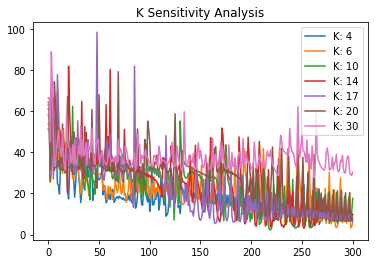

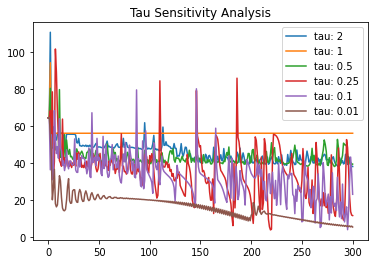

In [ ]:
#@title Sensitivity Analsysis



def tau_sensitivity():
                
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = [ 2, 1, 0.5, 0.25, 0.1, 0.01]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        tau = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="tau: "+ str(tau))
    
    plt.title("Tau Sensitivity Analysis")
    plt.legend()
    plt.show()
    
def tauI_sensitivity(I):
                
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = np.array([ 40, 20, 10, 5, 2, 0.2])/I
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        tau = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="tau: "+ str(tau*I) + "/I")
    
    plt.title("Tau Sensitivity Analysis, I: "+str(I))
    plt.legend()
    plt.show()
    
def I_selection():       
    var = [5, 10, 15, 20, 40, 80, 160, 320]
    for I in var:
        tauI_sensitivity(I)
    

def K_sensitivity():
             
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 4, 6, 10, 14, 17, 20, 30]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        K = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="K: "+ str(var[i]))
    
    plt.title("K Sensitivity Analysis")
    plt.legend()
    plt.show()

    

def h_sensitivity():
             
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 0.14, 0.12, 0.1, 0.07, 0.05, 0.01]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        h = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="h: "+ str(var[i]))
    
    plt.title("h Sensitivity Analysis")
    plt.legend()
    plt.show()


def d_sensitivity():
             
    b = generate_synthetic_batches(I)
    
    c, inv = scale(b["c"])
    Y = b["Y"]
    #Y = scale(b["Y"])
    d_0 = Y.shape[0]
    
    var = var = [ 2, 3, 4, 5,6,7,8, 10 ]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        d = var[i]
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, method="gd")
        plt.plot(it, JJ, label="d: "+ str(var[i]))
    
    plt.title("d Sensitivity Analysis")
    plt.legend()
    plt.show()

def I_sensitivity():
    max_it = 3000             
    var = var = [5, 10, 15, 20, 40, 80, 160, 320]
    it = np.arange(0,max_it+1)
    
    for i in range(len(var)):    
        I = var[i]
        b = generate_synthetic_batches(I)
        c, inv = scale(b["c"])
        Y = b["Y"]
        #Y = scale(b["Y"])
        d_0 = Y.shape[0]
    
        print("I:", I)
        th = initialize_weights(d_0, d, K)
        JJ,th = train(c, d, d_0, K, h, Y, th, tau=tau, max_it=max_it, print_it=False, method="gd")
        JJ = JJ/JJ[0]
        plt.plot(it, JJ, label="I: "+ str(var[i]))
    
    #plt.yscale("log")
    plt.title("I Sensitivity Analysis")
    plt.yscale("log")
    plt.legend()
    plt.show()    
    



# Default values based on the analysis
K = 20
h = 0.1
d_0 = 2
d = 4
I = 600
max_it = 300
tau = 0.1


K_sensitivity()
tau_sensitivity()
h_sensitivity()
d_sensitivity()
I_sensitivity()
I_selection()

(c) Train the model for the case of data given (with unknown Hamiltonian func-
tion).

In [ ]:

def train_uknown():
    K = 20
    h = 0.1
    I = 80
    max_it = 1
    sifts = 110
    tau = 0.1
    
    batches = import_batches()
    batch1 = batches[0]
    antB = 40
    testbatch = batches[antB-1]
    
    
    
    Y = batch1["Y_q"]
    d_0 = Y.shape[0]
    d = d_0*2
    
    
    th = initialize_weights(d_0, d, K)
    JJ = np.array([])
    
    
    bigbatch = {}
    bigbatch["Y"] = np.array([[],[],[]])
    bigbatch["c"] = np.array([])
    
    for i in range(antB):
        batch = batches[i]
        bigbatch["Y"] = np.append(bigbatch["Y"],batch["Y_q"],1)
        bigbatch["c"] = np.append(bigbatch["c"],batch["c_q"])
        
    Y = bigbatch["Y"]
    c,inv = scale(bigbatch["c"][:,np.newaxis])
    
    JJ, th = stocgradient(c, d, d_0, K, h, Y, th, tau, 1 , 40, sifts)
 
    plt.plot(JJ)
    plt.yscale("log")
    plt.show()
    
    tY = testbatch["Y_q"]
    tc,invscale = scale(testbatch["c_q"])
    
    z, yhat = F_tilde(tY, th, d_0, d, K, h)
    
    y = invscale(yhat)
    ic = invscale(tc)
    
    plt.plot(y)
    plt.plot(ic)
    plt.show()
    
    th_file = open("weights.pkl", "wb")
    pickle.dump(th, th_file)
    th_file.close()

